In [22]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, LSTM, Dropout
import os
import math
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
random.seed(5)

In [23]:
dir = os.path.normpath(os.getcwd() + os.sep + os.pardir)+"/Data/"

In [24]:
def metrics(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    print('MSE: '+str(mse))
    mae = mean_absolute_error(actual, predicted)
    print('MAE: '+str(mae))
    rmse = math.sqrt(mse)
    print('RMSE: '+str(rmse))
    return mse, mae, rmse

In [21]:
def load_model(X_train):
    #LSTM Model
	model = Sequential()
	model.add(LSTM(64, return_sequences=True,input_shape=(X_train.shape[1],X_train.shape[2])))
	model.add(Dropout(rate=0.1))

    """
    model.add(GRU(64, input_shape=(X_train.shape[1],X_train.shape[2])))
    model.add(Dense(period,activation='linear'))
    """
    return model

TabError: inconsistent use of tabs and spaces in indentation (266610731.py, line 4)

### Daily Data

In [15]:
data_arr = np.load(f"{dir}data_daily.npy")
dates = pd.date_range(start='1901-01-01', end='2018-12-31', freq='D')
df = pd.DataFrame({'Date':dates, 'Rain':data_arr[10,:]})

df.sort_values(by="Date", inplace=True)
split_index = df.loc[df['Date']==pd.to_datetime('2002-06-23', format='%Y-%m-%d')].index[0]
train_df, test_df = df[:split_index+1], df[split_index+1:]
train_len = len(train_df)
test_len = len(test_df)
train_df, test_df

(            Date      Rain
 0     1901-01-01  0.000000
 1     1901-01-02  0.000000
 2     1901-01-03  0.000000
 3     1901-01-04  0.000000
 4     1901-01-05  0.000000
 ...          ...       ...
 37059 2002-06-19  0.134756
 37060 2002-06-20  0.000000
 37061 2002-06-21  0.000000
 37062 2002-06-22  0.184818
 37063 2002-06-23  0.580242
 
 [37064 rows x 2 columns],
             Date       Rain
 37064 2002-06-24  54.036442
 37065 2002-06-25  14.797153
 37066 2002-06-26   0.906189
 37067 2002-06-27   5.933074
 37068 2002-06-28   0.230236
 ...          ...        ...
 43094 2018-12-27   0.000000
 43095 2018-12-28   0.000000
 43096 2018-12-29   0.000000
 43097 2018-12-30   0.000000
 43098 2018-12-31   0.000000
 
 [6035 rows x 2 columns])

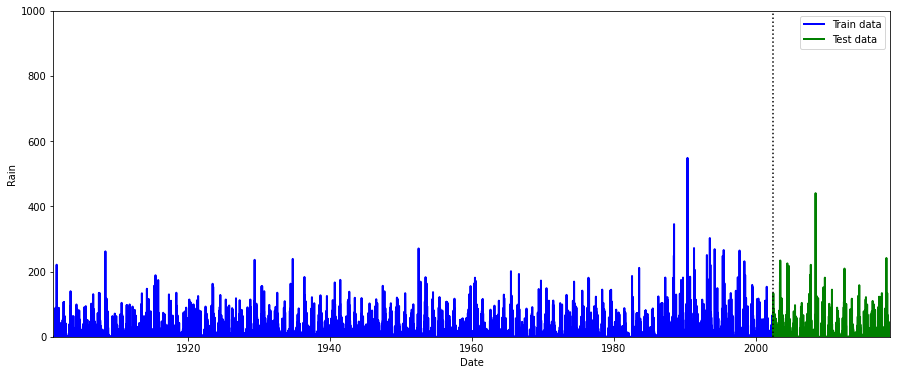

In [16]:
fig, ax = plt.subplots(figsize=(15,6))
plt.plot(train_df['Date'], train_df['Rain'], linewidth=2, color='blue', label='Train data')
plt.plot(test_df['Date'], test_df['Rain'], linewidth=2, color='green', label='Test data')
plt.vlines(x=pd.to_datetime('2002-06-23', format='%Y-%m-%d'), ymin=0, ymax=1000, color = 'k', linestyle=':')
plt.margins(x=0, y=0)
plt.xlabel('Date')
plt.ylabel('Rain')
plt.legend()
plt.show()

In [17]:
time_step = 7
period = 1

scaler = MinMaxScaler(feature_range=(0,1))
train_data_scaled = scaler.fit_transform(train_df.drop('Date',axis=1))

X_train = []
Y_train = []
for i in range(time_step,train_len):
    X_train.append(train_data_scaled[i-time_step:i,0])
    Y_train.append(train_data_scaled[i:i+period,0])

X_train, Y_train = np.array(X_train), np.array(Y_train)

X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

inp = df.drop('Date',axis=1)
inp = np.array(inp[(len(inp)-test_len-time_step):])

inp = scaler.transform(inp)

X_test = []

for i in range(time_step,test_len+time_step):
    X_test.append(inp[i-time_step:i,0])        
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))


In [18]:
model = load_model(X_train)

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, Y_train, epochs=5, batch_size=64, verbose=1)
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 7, 64)             16896     
                                                                 
 lstm_4 (LSTM)               (None, 32)                12416     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5


2022-12-20 18:29:03.854768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-20 18:29:04.390602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-20 18:29:04.475114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-20 18:29:04.705089: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-20 18:29:04.881432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


580/580 [==============================] - 33s 51ms/step - loss: 9.6947e-04
Epoch 2/5
580/580 [==============================] - 26s 45ms/step - loss: 9.3012e-04
Epoch 3/5
580/580 [==============================] - 26s 45ms/step - loss: 9.3032e-04
Epoch 4/5
580/580 [==============================] - 26s 45ms/step - loss: 9.2612e-04
Epoch 5/5
580/580 [==============================] - 27s 46ms/step - loss: 9.2240e-04


2022-12-20 18:31:20.391210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-20 18:31:20.578829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  4/189 [..............................] - ETA: 3s  

2022-12-20 18:31:20.687787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


189/189 [==============================] - 4s 17ms/step


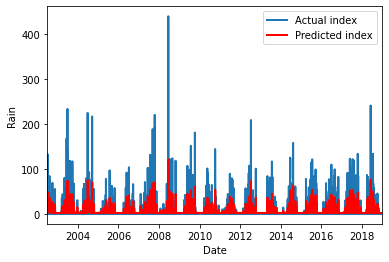

In [19]:
predict = pd.DataFrame(columns = ['Date','Rain', 'Prediction'])
pred_data = test_df
predict['Date'] = pred_data['Date'][0:len(predictions)]
predict['Rain'] = pred_data['Rain'][0:len(predictions)]
predict['Prediction'] = predictions[:,0]

plt.plot(predict['Date'], predict['Rain'], label='Actual index', linewidth=2)
plt.plot(predict['Date'], predict['Prediction'], label='Predicted index', color='red', linewidth=2)
plt.legend()
plt.margins(x=0)
plt.xlabel('Date')
plt.ylabel('Rain')

plt.show()

In [20]:
mse, mae, rmse = metrics(test_df['Rain'],predictions.reshape(test_df.shape[0]))

MSE: 314.8875639858062
MAE: 7.602755242842925
RMSE: 17.745071540735083


## Monthly Average Data

In [11]:
data_arr = np.load(f"{dir}monthly_avg.npy")
dates = pd.date_range(start='1901-01-01', end='2018-12-31', freq='m')
df = pd.DataFrame({'Date':dates, 'Rain':data_arr[10,:]})

df.sort_values(by="Date", inplace=True)
split_index = df.loc[df['Date']==pd.to_datetime('2002-06-30', format='%Y-%m-%d')].index[0]
train_df, test_df = df[:split_index+1], df[split_index+1:]
train_len = len(train_df)
test_len = len(test_df)
train_df, test_df

(           Date       Rain
 0    1901-01-31   0.000000
 1    1901-02-28   0.000000
 2    1901-03-31   0.164516
 3    1901-04-30   5.266666
 4    1901-05-31   2.200000
 ...         ...        ...
 1213 2002-02-28   0.000000
 1214 2002-03-31   3.700147
 1215 2002-04-30   3.710053
 1216 2002-05-31  11.961229
 1217 2002-06-30  11.412104
 
 [1218 rows x 2 columns],
            Date       Rain
 1218 2002-07-31  23.937438
 1219 2002-08-31  16.269363
 1220 2002-09-30   8.909159
 1221 2002-10-31   1.895902
 1222 2002-11-30   2.811913
 ...         ...        ...
 1411 2018-08-31  12.051821
 1412 2018-09-30   4.015899
 1413 2018-10-31   5.009404
 1414 2018-11-30   0.374468
 1415 2018-12-31   0.020417
 
 [198 rows x 2 columns])

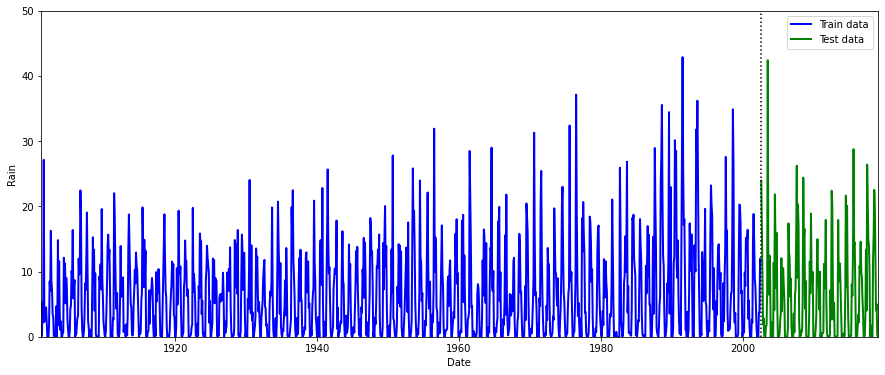

In [12]:
fig, ax = plt.subplots(figsize=(15,6))
plt.plot(train_df['Date'], train_df['Rain'], linewidth=2, color='blue', label='Train data')
plt.plot(test_df['Date'], test_df['Rain'], linewidth=2, color='green', label='Test data')
plt.vlines(x=pd.to_datetime('2002-06-23', format='%Y-%m-%d'), ymin=0, ymax=50, color = 'k', linestyle=':')
plt.margins(x=0, y=0)
plt.xlabel('Date')
plt.ylabel('Rain')
plt.legend()
plt.show()

In [13]:
time_step = 1
period = 1

train_data_scaled = scaler.fit_transform(train_df.drop('Date',axis=1))

X_train = []
Y_train = []
for i in range(time_step,train_len):
    X_train.append(train_data_scaled[i-time_step:i,0])
    Y_train.append(train_data_scaled[i:i+period,0])

X_train, Y_train = np.array(X_train), np.array(Y_train)

X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

inp = df.drop('Date',axis=1)
inp = np.array(inp[(len(inp)-test_len-time_step):])

inp = scaler.transform(inp)

X_test = []

for i in range(time_step,test_len+time_step):
    X_test.append(inp[i-time_step:i,0])        
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [14]:
model = load_model(X_train)

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, Y_train, epochs=5, batch_size=150, verbose=1)
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 64)                12864     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 12,929
Trainable params: 12,929
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5


2022-12-15 20:38:18.629155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-15 20:38:18.884019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-15 20:38:19.046140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 2s 40ms/step - loss: 0.0384
Epoch 2/5
9/9 [==============================] - 0s 23ms/step - loss: 0.0246
Epoch 3/5
9/9 [==============================] - 0s 28ms/step - loss: 0.0221
Epoch 4/5
9/9 [==============================] - 0s 28ms/step - loss: 0.0216
Epoch 5/5
1/7 [===>..........................] - ETA: 2s

2022-12-15 20:38:20.801469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-15 20:38:20.915023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 1s 71ms/step


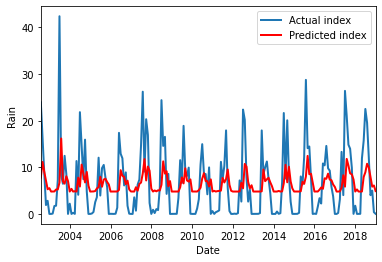

In [15]:
predict = pd.DataFrame(columns = ['Date','Rain', 'Prediction'])
pred_data = test_df
predict['Date'] = pred_data['Date'][0:len(predictions)]
predict['Rain'] = pred_data['Rain'][0:len(predictions)]
predict['Prediction'] = predictions[:,0]

plt.plot(predict['Date'], predict['Rain'], label='Actual index', linewidth=2)
plt.plot(predict['Date'], predict['Prediction'], label='Predicted index', color='red', linewidth=2)
plt.legend()
plt.margins(x=0)
plt.xlabel('Date')
plt.ylabel('Rain')

plt.show()

In [16]:
mse, mae, rmse = metrics(test_df['Rain'],predictions.reshape(test_df.shape[0]))

MSE: 44.25351752793822
MAE: 5.138740833008717
RMSE: 6.652331736161256
